# Fit conic to real data from proplyd arcs

We will use the same data that we used in Tarango Yong & Henney (2018) to demonstrate the circle-fit algorithm.



## Imports

In [1]:
import time

In [2]:
start_time = time.time()
from pathlib import Path
import sys
import confitti
import numpy as np
import lmfit
from matplotlib import pyplot as plt
import seaborn as sns
import regions as rg
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [4]:
sns.set_context("notebook", font_scale=1.2)

## Set up the arc data

In [5]:
datapath = Path.cwd().parent / "data"
figpath = Path.cwd().parent / "figs"
saveprefix = "demo03"

### Read arc points in celestial coordinates from DS9-format regions file

This function is copied over from the circle-fit project with some updates to reflect more recent API changes

In [6]:
def read_arc_data_ds9(filename, pt_star="o", pt_arc="x"):
    """
    Return the sky coordinates of a star (single point of type
    `pt_star`) and arc (multiple points of type: `pt_arc`), which are
    read from the DS9 region file `filename`
    """
    regions = rg.Regions.read(filename)

    try:
        (star,) = [x for x in regions if x.visual["marker"] == pt_star]
    except IndexError:
        sys.exit("One and only one 'circle' region is required")
    points = [x for x in regions if x.visual["marker"] == pt_arc]
    return star, points

In [7]:
filename = datapath / "new-069-601-ridge.reg"
regions = rg.Regions.read(filename)

In [8]:
regions[0].meta

{'select': 1,
 'highlite': 1,
 'fixed': 0,
 'edit': 1,
 'move': 1,
 'delete': 1,
 'include': 1,
 'source': 1}

In [9]:
regions[0].visual

{'color': 'green',
 'default_style': 'ds9',
 'marker': 'o',
 'fontname': 'helvetica',
 'fontsize': 10,
 'fontweight': 'normal',
 'fontstyle': 'normal',
 'markeredgewidth': 1}

In [10]:
regions[1].visual

{'color': 'green',
 'default_style': 'ds9',
 'marker': 'x',
 'fontname': 'helvetica',
 'fontsize': 10,
 'fontweight': 'normal',
 'fontstyle': 'normal',
 'markeredgewidth': 1}

In [11]:
star, points = read_arc_data_ds9(datapath / "new-069-601-ridge.reg")

In [12]:
star.center

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (83.77878333, -5.43349444)>

### Convert to Cartesian x, y pixel coordinates

We use a WCS transformation to put the arc in simple x, y coordinates so we do not need to worry about any astro stuff for a while. We could get the WCS from a fits image header, but instead we will just construct a grid centered on the star with 0.1 arcsec pixels.


In [13]:
w = WCS(naxis=2)
w.wcs.crpix = [0, 0]
w.wcs.cdelt = np.array([-0.1, 0.1]) / 3600
w.wcs.crval = [star.center.ra.deg, star.center.dec.deg]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 83.77878333333331 -5.433494444444444 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -2.777777777777778e-05 2.777777777777778e-05 
NAXIS : 0  0

In [14]:
xpts, ypts = SkyCoord([point.center for point in points]).to_pixel(w)

## Plot the points

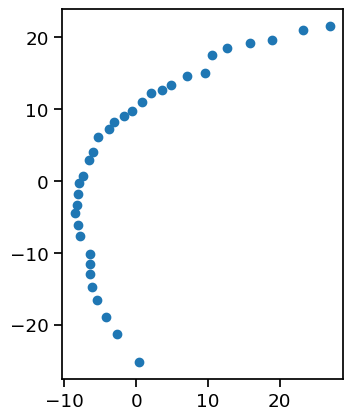

In [15]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts)
ax.set_aspect("equal")
...;

## Fit the arc

In [16]:
result_p = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=True)
result_e = confitti.fit_conic_to_xy(xpts, ypts, only_parabola=False)

In [17]:
result_e

In [18]:
beste_xy = confitti.XYconic(**result_e.params.valuesdict())
print(beste_xy)
bestp_xy = confitti.XYconic(**result_p.params.valuesdict())
print(bestp_xy)

Conic section curve with focus at (-0.3214693610875962, -1.385393316316501), scale factor 7.505353906005249, angle 162.3180114688275, and eccentricity 1.0830661103716528.
Conic section curve with focus at (0.4869373342069578, -2.0661043228703413), scale factor 8.385367588294274, angle 163.92944121537, and eccentricity 1.0.


/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


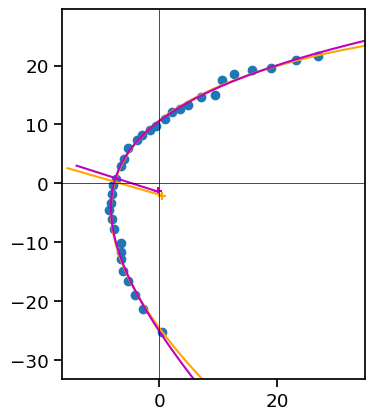

In [19]:
fig, ax = plt.subplots()
ax.scatter(xpts, ypts)

for xy, c in [[bestp_xy, "orange"], [beste_xy, "m"]]:
    ax.plot(xy.x_pts, xy.y_pts, color=c)
    ax.scatter(xy.x0, xy.y0, marker="+", color=c)
    ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color=c)

ax.axhline(0, lw=0.5, c="k")
ax.axvline(0, lw=0.5, c="k")
ax.set_aspect("equal")
margin = 8
ax.set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
...;

In [20]:
fig.savefig(figpath / f"{saveprefix}-best-fits.pdf", bbox_inches="tight")

Ellipsis

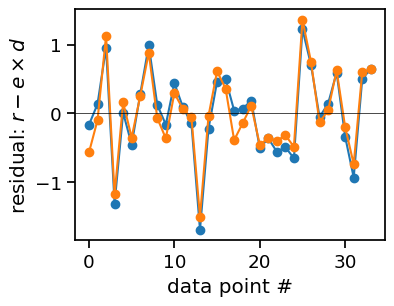

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(result_p.residual, "-o")
ax.plot(result_e.residual, "-o")
ax.axhline(0, color="k", lw=0.5)
ax.set(
    xlabel="data point #",
    ylabel=r"residual: $r - e \times d$",
)
...

In [22]:
fig.savefig(figpath / f"{saveprefix}-residuals.pdf", bbox_inches="tight")

## Calculate posterior probability of parameters with emcee



In [23]:
emcee_kws = dict(
    steps=5000,
    burn=1000,
    thin=20,
    is_weighted=False,
    progress=False,
    workers=16,
    nan_policy="omit",
)
emcee_params = result_e.params.copy()
emcee_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(1.0))

In [24]:
result_emcee = lmfit.minimize(
    confitti.residual,
    args=(xpts, ypts),
    method="emcee",
    params=emcee_params,
    **emcee_kws,
)

In [25]:
result_emcee

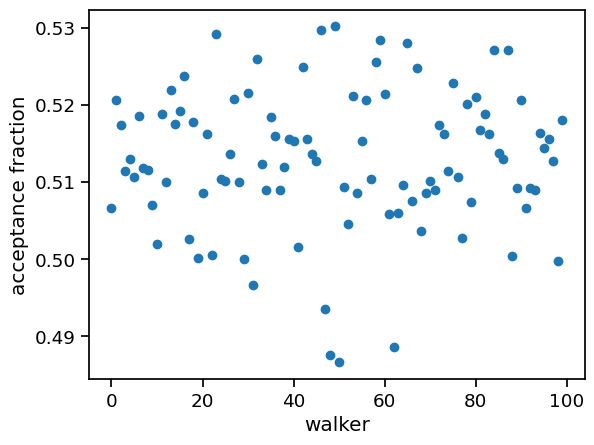

In [26]:
plt.plot(result_emcee.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance fraction")
plt.show()

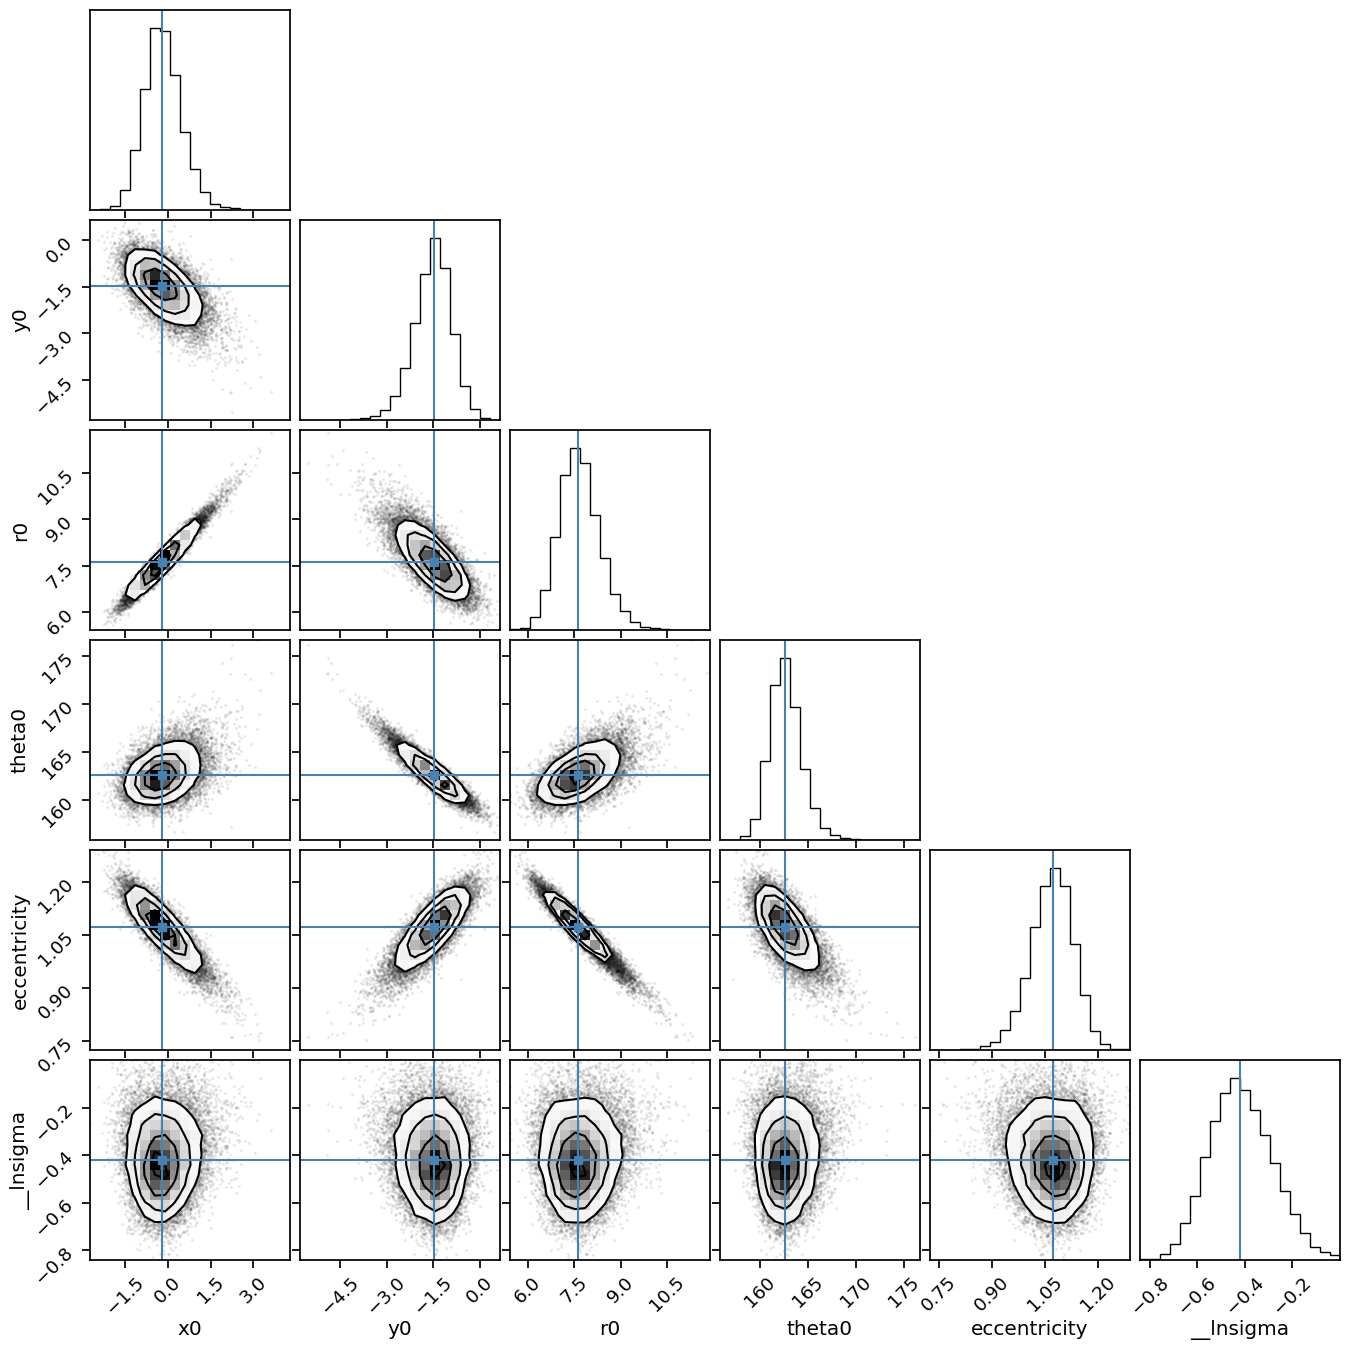

In [27]:
import corner

emcee_plot = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [28]:
emcee_plot.savefig(figpath / f"{saveprefix}-corner.pdf", bbox_inches="tight")

In [29]:
best_xy = confitti.XYconic(**result_e.params.valuesdict())
chain_pars = result_emcee.flatchain.drop(columns="__lnsigma").to_dict(orient="records")
chain_xy = [confitti.XYconic(**row) for row in chain_pars[7::200]]

/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0
/Users/will/Dropbox/confitti/src/confitti/confitti.py:131: RuntimeWarning: divide by zero encountered in divide
  self.r0


In [30]:
len(chain_xy)

100

In [31]:
import matplotlib as mpl

In [32]:
cmap = mpl.cm.rainbow

In [33]:
eparam = result_emcee.params["eccentricity"]
emin, emax = eparam.value - 2 * eparam.stderr, eparam.value + 2 * eparam.stderr
norm = mpl.colors.Normalize(vmin=emin, vmax=emax)
norm(1.0)

0.199100631168867

Ellipsis

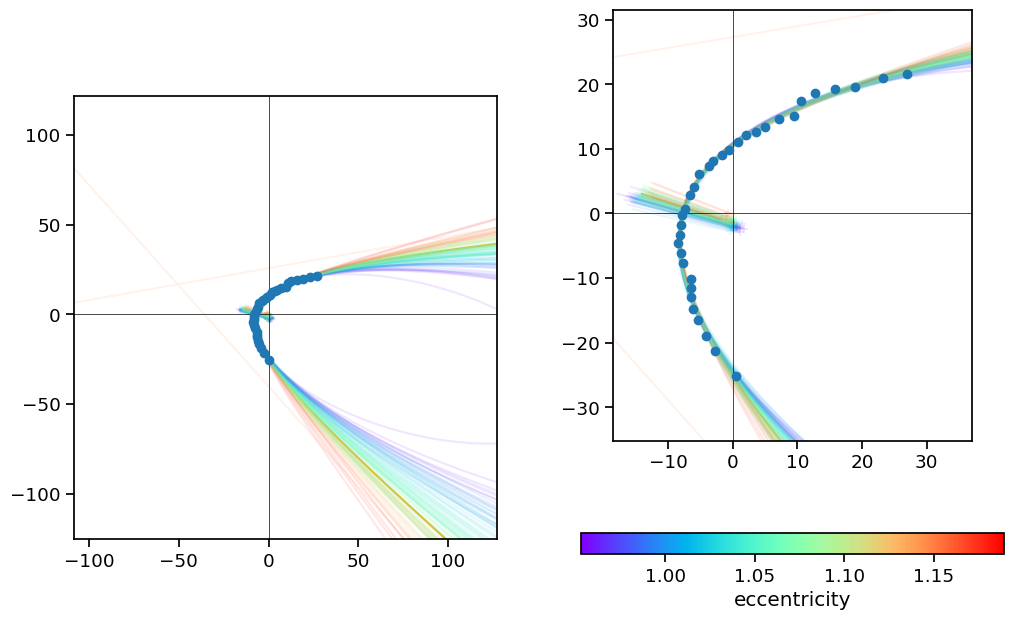

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for ax in axes:
    c = "orange"
    ax.plot(best_xy.x_pts, best_xy.y_pts, color=c)
    ax.scatter(best_xy.x0, best_xy.y0, marker="+", color=c)
    ax.plot([best_xy.x0, best_xy.x_mirror], [best_xy.y0, best_xy.y_mirror], color=c)

    c = "m"
    alpha = 0.1
    for xy in chain_xy:
        c = cmap(norm(xy.eccentricity))
        ax.plot(xy.x_pts, xy.y_pts, color=c, alpha=alpha)
        ax.scatter(xy.x0, xy.y0, marker="+", color=c, alpha=alpha)
        ax.plot([xy.x0, xy.x_mirror], [xy.y0, xy.y_mirror], color=c, alpha=alpha)
    ax.scatter(xpts, ypts, zorder=1000)
    ax.axhline(0, lw=0.5, c="k")
    ax.axvline(0, lw=0.5, c="k")
    ax.set_aspect("equal")

margin = 100
axes[0].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)
margin = 10
axes[1].set(
    xlim=[xpts.min() - margin, xpts.max() + margin],
    ylim=[ypts.min() - margin, ypts.max() + margin],
)

fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes[1],
    orientation="horizontal",
    label="eccentricity",
)
...

In [35]:
fig.savefig(figpath / f"{saveprefix}-emcee-samples.pdf", bbox_inches="tight")

## Execution time for notebook

In [36]:
print(f"--- {time.time() - start_time} seconds ---")

--- 53.98224377632141 seconds ---
